# Denoising autoencoder

Modified from https://github.com/eugeniaring/Pytorch-tutorial/blob/main/denAE.ipynb

In [1]:
# Imports
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from random import sample
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST

## Download MNIST and show some samples

In [2]:
# Download training and testset of MNIST
train_dataset = MNIST('../../data', train=True, download=True, transform=transforms.ToTensor())
val_dataset = MNIST('../../data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512)

## Define the autoencoder

In [4]:
# Autoencoder class
class AutoEncoder(nn.Module):

    def __init__(self, img_size, code_size):
        super().__init__()
        self.img_size = img_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(3*3*32, code_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(code_size, 3*3*32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    # Forward pass
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.reshape(-1, 1, self.img_size, self.img_size)

## Initialize model, loss and optimizer

In [5]:
# Set params
img_size = 28
code_size = 8

# Create model
model = AutoEncoder(img_size, code_size)

# Set training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set model to device
model.to(device)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model

In [6]:
# Function to add noise to images
def add_noise(inputs, noise_factor=0.3):
    noise = inputs + noise_factor * torch.randn_like(inputs)
    noise = torch.clip(noise, 0., 1.)
    return noise

In [7]:
# Set training params
num_epochs = 10
noise_factor = 0.3

# Init results
train_losses = []
val_losses = []

# Loop over all epochs
for epoch in range(num_epochs):

    # Set model to train
    model.train()
    
    # Loop over all batches
    for image_batch, _ in tqdm(train_loader):

        # Add noise to image
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        # Predict denoised image
        denoised_data = model(image_noisy)

        # Compute error between original image and predicted image
        loss = loss_fn(denoised_data, image_batch.to(device))

        # Step optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append results
        train_losses.append(loss.detach().cpu().numpy())

    # Set model to evaluate
    model.eval()

    # Loop over all batches
    epoch_val_losses = []
    for image_batch, _ in tqdm(val_loader):

        # Add noise to image
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        # Predict denoised image
        with torch.no_grad(): denoised_data = model(image_noisy)

        # Compute error between original image and predicted image
        val_loss = loss_fn(denoised_data, image_batch.to(device))

        # Append results
        epoch_val_losses.append(val_loss.cpu().numpy())

    # Append validation losses
    val_losses.append(np.mean(epoch_val_losses))

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  1%|█▎                                                                                                                                                              | 1/118 [00:00<00:42,  2.73it/s]

  4%|██████▊                                                                                                                                                         | 5/118 [00:00<00:09, 12.35it/s]

  8%|████████████▏                                                                                                                                                   | 9/118 [00:00<00:05, 18.89it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:05, 19.35it/s]

 14%|█████████████████████▌                                                                                                                                         | 16/118 [00:00<00:04, 23.28it/s]

 17%|██████████████████████████▉                                                                                                                                    | 20/118 [00:01<00:03, 26.16it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:01<00:03, 28.33it/s]

 24%|█████████████████████████████████████▋                                                                                                                         | 28/118 [00:01<00:03, 29.70it/s]

 27%|███████████████████████████████████████████                                                                                                                    | 32/118 [00:01<00:02, 30.46it/s]

 31%|████████████████████████████████████████████████▌                                                                                                              | 36/118 [00:01<00:02, 31.10it/s]

 34%|█████████████████████████████████████████████████████▉                                                                                                         | 40/118 [00:01<00:02, 31.71it/s]

 37%|███████████████████████████████████████████████████████████▎                                                                                                   | 44/118 [00:01<00:02, 32.02it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 48/118 [00:01<00:02, 32.04it/s]

 44%|██████████████████████████████████████████████████████████████████████                                                                                         | 52/118 [00:01<00:02, 31.93it/s]

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                   | 56/118 [00:02<00:01, 31.37it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 60/118 [00:02<00:01, 30.70it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 64/118 [00:02<00:01, 30.75it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 68/118 [00:02<00:01, 30.32it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 72/118 [00:02<00:01, 30.28it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 76/118 [00:02<00:01, 30.39it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 80/118 [00:02<00:01, 30.67it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 84/118 [00:03<00:01, 30.99it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 88/118 [00:03<00:00, 31.36it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 92/118 [00:03<00:00, 31.66it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 96/118 [00:03<00:00, 31.67it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 100/118 [00:03<00:00, 29.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 103/118 [00:03<00:00, 29.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 106/118 [00:03<00:00, 29.47it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 110/118 [00:03<00:00, 30.02it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 114/118 [00:04<00:00, 30.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 29.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 28.30it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 20%|████████████████████████████████▏                                                                                                                                | 4/20 [00:00<00:00, 35.04it/s]

 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 8/20 [00:00<00:00, 34.36it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12/20 [00:00<00:00, 34.37it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 16/20 [00:00<00:00, 34.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.76it/s]

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  3%|█████▍                                                                                                                                                          | 4/118 [00:00<00:03, 31.94it/s]

  7%|██████████▊                                                                                                                                                     | 8/118 [00:00<00:03, 31.82it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:03, 31.80it/s]

 14%|█████████████████████▌                                                                                                                                         | 16/118 [00:00<00:03, 31.10it/s]

 17%|██████████████████████████▉                                                                                                                                    | 20/118 [00:00<00:03, 31.26it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:00<00:02, 31.48it/s]

 24%|█████████████████████████████████████▋                                                                                                                         | 28/118 [00:00<00:02, 31.98it/s]

 27%|███████████████████████████████████████████                                                                                                                    | 32/118 [00:01<00:02, 29.14it/s]

 30%|███████████████████████████████████████████████▏                                                                                                               | 35/118 [00:01<00:02, 27.67it/s]

 32%|███████████████████████████████████████████████████▏                                                                                                           | 38/118 [00:01<00:02, 28.21it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                      | 42/118 [00:01<00:02, 29.11it/s]

 39%|█████████████████████████████████████████████████████████████▉                                                                                                 | 46/118 [00:01<00:02, 29.70it/s]

 42%|███████████████████████████████████████████████████████████████████▎                                                                                           | 50/118 [00:01<00:02, 30.26it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 54/118 [00:01<00:02, 30.95it/s]

 49%|██████████████████████████████████████████████████████████████████████████████▏                                                                                | 58/118 [00:01<00:01, 31.09it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                           | 62/118 [00:02<00:01, 31.51it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66/118 [00:02<00:01, 31.91it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 70/118 [00:02<00:01, 32.18it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 74/118 [00:02<00:01, 32.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 78/118 [00:02<00:01, 32.80it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 82/118 [00:02<00:01, 32.58it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 86/118 [00:02<00:01, 31.74it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 90/118 [00:02<00:00, 32.10it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 94/118 [00:03<00:00, 32.50it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 98/118 [00:03<00:00, 32.56it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 102/118 [00:03<00:00, 32.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 106/118 [00:03<00:00, 33.07it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 110/118 [00:03<00:00, 33.04it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 114/118 [00:03<00:00, 33.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 34.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.76it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 20%|████████████████████████████████▏                                                                                                                                | 4/20 [00:00<00:00, 36.15it/s]

 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 8/20 [00:00<00:00, 36.43it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12/20 [00:00<00:00, 36.44it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 16/20 [00:00<00:00, 36.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 37.50it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 36.93it/s]

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  3%|█████▍                                                                                                                                                          | 4/118 [00:00<00:03, 33.27it/s]

  7%|██████████▊                                                                                                                                                     | 8/118 [00:00<00:03, 33.15it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:03, 32.49it/s]

 14%|█████████████████████▌                                                                                                                                         | 16/118 [00:00<00:03, 32.13it/s]

 17%|██████████████████████████▉                                                                                                                                    | 20/118 [00:00<00:03, 32.62it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:00<00:02, 32.83it/s]

 24%|█████████████████████████████████████▋                                                                                                                         | 28/118 [00:00<00:02, 33.00it/s]

 27%|███████████████████████████████████████████                                                                                                                    | 32/118 [00:00<00:02, 33.02it/s]

 31%|████████████████████████████████████████████████▌                                                                                                              | 36/118 [00:01<00:02, 32.97it/s]

 34%|█████████████████████████████████████████████████████▉                                                                                                         | 40/118 [00:01<00:02, 32.93it/s]

 37%|███████████████████████████████████████████████████████████▎                                                                                                   | 44/118 [00:01<00:02, 33.06it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 48/118 [00:01<00:02, 32.76it/s]

 44%|██████████████████████████████████████████████████████████████████████                                                                                         | 52/118 [00:01<00:02, 32.84it/s]

 47%|███████████████████████████████████████████████████████████████████████████▍                                                                                   | 56/118 [00:01<00:01, 33.13it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 60/118 [00:01<00:01, 32.71it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 64/118 [00:01<00:01, 32.01it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 68/118 [00:02<00:01, 31.52it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 72/118 [00:02<00:01, 31.25it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 76/118 [00:02<00:01, 31.21it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 80/118 [00:02<00:01, 30.91it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 84/118 [00:02<00:01, 30.80it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 88/118 [00:02<00:00, 30.75it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 92/118 [00:02<00:00, 30.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 96/118 [00:03<00:00, 30.33it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 100/118 [00:03<00:00, 30.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 104/118 [00:03<00:00, 29.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 107/118 [00:03<00:00, 29.53it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 110/118 [00:03<00:00, 29.31it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 113/118 [00:03<00:00, 28.90it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 116/118 [00:03<00:00, 28.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.48it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 20%|████████████████████████████████▏                                                                                                                                | 4/20 [00:00<00:00, 32.46it/s]

 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 8/20 [00:00<00:00, 32.69it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12/20 [00:00<00:00, 32.73it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 16/20 [00:00<00:00, 31.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 32.11it/s]

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  3%|████                                                                                                                                                            | 3/118 [00:00<00:04, 25.75it/s]

  5%|████████▏                                                                                                                                                       | 6/118 [00:00<00:04, 26.39it/s]

  8%|████████████▏                                                                                                                                                   | 9/118 [00:00<00:04, 26.24it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:04, 25.79it/s]

 13%|████████████████████▏                                                                                                                                          | 15/118 [00:00<00:03, 25.93it/s]

 15%|████████████████████████▎                                                                                                                                      | 18/118 [00:00<00:03, 25.76it/s]

 18%|████████████████████████████▎                                                                                                                                  | 21/118 [00:00<00:03, 25.97it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:00<00:03, 25.44it/s]

 23%|████████████████████████████████████▍                                                                                                                          | 27/118 [00:01<00:03, 25.48it/s]

 25%|████████████████████████████████████████▍                                                                                                                      | 30/118 [00:01<00:03, 25.23it/s]

 28%|████████████████████████████████████████████▍                                                                                                                  | 33/118 [00:01<00:03, 25.52it/s]

 31%|████████████████████████████████████████████████▌                                                                                                              | 36/118 [00:01<00:03, 25.34it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                          | 39/118 [00:01<00:03, 25.63it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                      | 42/118 [00:01<00:02, 25.62it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                  | 45/118 [00:01<00:02, 25.41it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 48/118 [00:01<00:02, 25.42it/s]

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 51/118 [00:01<00:02, 25.52it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 54/118 [00:02<00:02, 25.61it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                  | 57/118 [00:02<00:02, 25.71it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 60/118 [00:02<00:02, 25.57it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 63/118 [00:02<00:02, 25.49it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66/118 [00:02<00:02, 25.37it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 69/118 [00:02<00:01, 24.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 72/118 [00:02<00:01, 25.10it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 75/118 [00:02<00:01, 24.96it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 78/118 [00:03<00:01, 24.97it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 81/118 [00:03<00:01, 24.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 84/118 [00:03<00:01, 24.93it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 87/118 [00:03<00:01, 24.96it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 90/118 [00:03<00:01, 24.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 93/118 [00:03<00:01, 24.70it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 96/118 [00:03<00:00, 24.19it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 99/118 [00:03<00:00, 24.24it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 102/118 [00:04<00:00, 24.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 105/118 [00:04<00:00, 24.39it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 108/118 [00:04<00:00, 24.04it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 111/118 [00:04<00:00, 23.73it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 114/118 [00:04<00:00, 23.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 117/118 [00:04<00:00, 23.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 25.15it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 15%|████████████████████████▏                                                                                                                                        | 3/20 [00:00<00:00, 28.50it/s]

 30%|████████████████████████████████████████████████▎                                                                                                                | 6/20 [00:00<00:00, 28.98it/s]

 45%|████████████████████████████████████████████████████████████████████████▍                                                                                        | 9/20 [00:00<00:00, 28.68it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12/20 [00:00<00:00, 28.45it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 15/20 [00:00<00:00, 28.29it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 19/20 [00:00<00:00, 29.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.60it/s]

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  3%|████                                                                                                                                                            | 3/118 [00:00<00:05, 22.87it/s]

  5%|████████▏                                                                                                                                                       | 6/118 [00:00<00:04, 23.28it/s]

  8%|████████████▏                                                                                                                                                   | 9/118 [00:00<00:04, 23.11it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:04, 23.16it/s]

 13%|████████████████████▏                                                                                                                                          | 15/118 [00:00<00:04, 23.21it/s]

 15%|████████████████████████▎                                                                                                                                      | 18/118 [00:00<00:04, 23.30it/s]

 18%|████████████████████████████▎                                                                                                                                  | 21/118 [00:00<00:04, 23.37it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:01<00:04, 23.39it/s]

 23%|████████████████████████████████████▍                                                                                                                          | 27/118 [00:01<00:03, 23.29it/s]

 25%|████████████████████████████████████████▍                                                                                                                      | 30/118 [00:01<00:03, 23.34it/s]

 28%|████████████████████████████████████████████▍                                                                                                                  | 33/118 [00:01<00:03, 23.29it/s]

 31%|████████████████████████████████████████████████▌                                                                                                              | 36/118 [00:01<00:03, 23.34it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                          | 39/118 [00:01<00:03, 23.35it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                      | 42/118 [00:01<00:03, 23.41it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                  | 45/118 [00:01<00:03, 23.40it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 48/118 [00:02<00:03, 23.32it/s]

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 51/118 [00:02<00:02, 23.43it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 54/118 [00:02<00:02, 23.35it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                  | 57/118 [00:02<00:02, 23.39it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 60/118 [00:02<00:02, 23.43it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 63/118 [00:02<00:02, 23.25it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66/118 [00:02<00:02, 22.89it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 69/118 [00:02<00:02, 22.99it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 72/118 [00:03<00:01, 23.02it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 75/118 [00:03<00:01, 23.00it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 78/118 [00:03<00:01, 23.14it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 81/118 [00:03<00:01, 23.22it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 84/118 [00:03<00:01, 23.39it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 87/118 [00:03<00:01, 23.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 90/118 [00:03<00:01, 23.17it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 93/118 [00:04<00:01, 23.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 96/118 [00:04<00:00, 23.28it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 99/118 [00:04<00:00, 22.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 102/118 [00:04<00:00, 22.79it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 105/118 [00:04<00:00, 22.57it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 108/118 [00:04<00:00, 22.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 111/118 [00:04<00:00, 22.85it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 114/118 [00:04<00:00, 23.10it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 117/118 [00:05<00:00, 23.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 23.31it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 20%|████████████████████████████████▏                                                                                                                                | 4/20 [00:00<00:00, 30.05it/s]

 40%|████████████████████████████████████████████████████████████████▍                                                                                                | 8/20 [00:00<00:00, 28.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11/20 [00:00<00:00, 29.19it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 14/20 [00:00<00:00, 28.99it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 17/20 [00:00<00:00, 29.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.80it/s]

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  3%|████                                                                                                                                                            | 3/118 [00:00<00:05, 22.27it/s]

  5%|████████▏                                                                                                                                                       | 6/118 [00:00<00:04, 22.48it/s]

  8%|████████████▏                                                                                                                                                   | 9/118 [00:00<00:04, 22.71it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:04, 22.57it/s]

 13%|████████████████████▏                                                                                                                                          | 15/118 [00:00<00:04, 22.57it/s]

 15%|████████████████████████▎                                                                                                                                      | 18/118 [00:00<00:04, 22.75it/s]

 18%|████████████████████████████▎                                                                                                                                  | 21/118 [00:00<00:04, 22.46it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:01<00:04, 22.29it/s]

 23%|████████████████████████████████████▍                                                                                                                          | 27/118 [00:01<00:04, 22.22it/s]

 25%|████████████████████████████████████████▍                                                                                                                      | 30/118 [00:01<00:03, 22.54it/s]

 28%|████████████████████████████████████████████▍                                                                                                                  | 33/118 [00:01<00:03, 22.81it/s]

 31%|████████████████████████████████████████████████▌                                                                                                              | 36/118 [00:01<00:03, 22.75it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                          | 39/118 [00:01<00:03, 22.84it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                      | 42/118 [00:01<00:03, 22.68it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                  | 45/118 [00:01<00:03, 22.70it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 48/118 [00:02<00:03, 22.70it/s]

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 51/118 [00:02<00:02, 22.75it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 54/118 [00:02<00:02, 22.85it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                  | 57/118 [00:02<00:02, 23.09it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 60/118 [00:02<00:02, 23.06it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 63/118 [00:02<00:02, 22.86it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66/118 [00:02<00:02, 22.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 69/118 [00:03<00:02, 22.94it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 72/118 [00:03<00:02, 22.58it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 75/118 [00:03<00:02, 19.55it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 78/118 [00:03<00:01, 20.04it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 81/118 [00:03<00:01, 20.70it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 84/118 [00:03<00:01, 20.33it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 87/118 [00:03<00:01, 20.52it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 90/118 [00:04<00:01, 21.17it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 93/118 [00:04<00:01, 21.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 96/118 [00:04<00:01, 21.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 99/118 [00:04<00:00, 22.17it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 102/118 [00:04<00:00, 22.50it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 105/118 [00:04<00:00, 22.50it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 108/118 [00:04<00:00, 22.47it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 111/118 [00:05<00:00, 22.14it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 114/118 [00:05<00:00, 22.44it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 117/118 [00:05<00:00, 22.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 22.30it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 15%|████████████████████████▏                                                                                                                                        | 3/20 [00:00<00:00, 28.61it/s]

 30%|████████████████████████████████████████████████▎                                                                                                                | 6/20 [00:00<00:00, 29.01it/s]

 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 10/20 [00:00<00:00, 29.57it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13/20 [00:00<00:00, 29.67it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 17/20 [00:00<00:00, 29.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.08it/s]

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  3%|████                                                                                                                                                            | 3/118 [00:00<00:04, 23.06it/s]

  5%|████████▏                                                                                                                                                       | 6/118 [00:00<00:04, 23.20it/s]

  8%|████████████▏                                                                                                                                                   | 9/118 [00:00<00:04, 23.17it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:04, 22.80it/s]

 13%|████████████████████▏                                                                                                                                          | 15/118 [00:00<00:04, 23.16it/s]

 15%|████████████████████████▎                                                                                                                                      | 18/118 [00:00<00:04, 23.16it/s]

 18%|████████████████████████████▎                                                                                                                                  | 21/118 [00:00<00:04, 22.93it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:01<00:04, 22.79it/s]

 23%|████████████████████████████████████▍                                                                                                                          | 27/118 [00:01<00:03, 22.90it/s]

 25%|████████████████████████████████████████▍                                                                                                                      | 30/118 [00:01<00:03, 22.74it/s]

 28%|████████████████████████████████████████████▍                                                                                                                  | 33/118 [00:01<00:03, 22.74it/s]

 31%|████████████████████████████████████████████████▌                                                                                                              | 36/118 [00:01<00:03, 22.98it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                          | 39/118 [00:01<00:03, 23.19it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                      | 42/118 [00:01<00:03, 23.16it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                  | 45/118 [00:01<00:03, 23.15it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 48/118 [00:02<00:03, 22.79it/s]

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 51/118 [00:02<00:02, 22.71it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 54/118 [00:02<00:02, 22.71it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                  | 57/118 [00:02<00:02, 22.68it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 60/118 [00:02<00:02, 21.90it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 63/118 [00:02<00:02, 21.55it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66/118 [00:02<00:02, 21.79it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 69/118 [00:03<00:02, 22.13it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 72/118 [00:03<00:02, 21.97it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 75/118 [00:03<00:01, 22.06it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 78/118 [00:03<00:01, 22.15it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 81/118 [00:03<00:01, 22.19it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 84/118 [00:03<00:01, 22.36it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 87/118 [00:03<00:01, 22.50it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 90/118 [00:03<00:01, 22.47it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 93/118 [00:04<00:01, 22.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 96/118 [00:04<00:00, 22.04it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 99/118 [00:04<00:00, 22.45it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 102/118 [00:04<00:00, 22.45it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 105/118 [00:04<00:00, 22.89it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 108/118 [00:04<00:00, 23.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 111/118 [00:04<00:00, 22.97it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 114/118 [00:05<00:00, 22.90it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 117/118 [00:05<00:00, 22.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 22.74it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 15%|████████████████████████▏                                                                                                                                        | 3/20 [00:00<00:00, 27.63it/s]

 30%|████████████████████████████████████████████████▎                                                                                                                | 6/20 [00:00<00:00, 27.92it/s]

 45%|████████████████████████████████████████████████████████████████████████▍                                                                                        | 9/20 [00:00<00:00, 28.32it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12/20 [00:00<00:00, 28.93it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 15/20 [00:00<00:00, 28.87it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 18/20 [00:00<00:00, 27.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.89it/s]

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  3%|████                                                                                                                                                            | 3/118 [00:00<00:04, 23.42it/s]

  5%|████████▏                                                                                                                                                       | 6/118 [00:00<00:05, 21.74it/s]

  8%|████████████▏                                                                                                                                                   | 9/118 [00:00<00:04, 22.06it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:04, 21.96it/s]

 13%|████████████████████▏                                                                                                                                          | 15/118 [00:00<00:04, 22.03it/s]

 15%|████████████████████████▎                                                                                                                                      | 18/118 [00:00<00:04, 22.12it/s]

 18%|████████████████████████████▎                                                                                                                                  | 21/118 [00:00<00:04, 22.44it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:01<00:04, 22.23it/s]

 23%|████████████████████████████████████▍                                                                                                                          | 27/118 [00:01<00:04, 22.51it/s]

 25%|████████████████████████████████████████▍                                                                                                                      | 30/118 [00:01<00:03, 22.51it/s]

 28%|████████████████████████████████████████████▍                                                                                                                  | 33/118 [00:01<00:03, 22.52it/s]

 31%|████████████████████████████████████████████████▌                                                                                                              | 36/118 [00:01<00:03, 22.63it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                          | 39/118 [00:01<00:03, 22.89it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                      | 42/118 [00:01<00:03, 22.43it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                  | 45/118 [00:02<00:03, 22.66it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 48/118 [00:02<00:03, 22.93it/s]

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 51/118 [00:02<00:02, 22.71it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 54/118 [00:02<00:02, 22.86it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                  | 57/118 [00:02<00:02, 22.96it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 60/118 [00:02<00:02, 22.87it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 63/118 [00:02<00:02, 22.74it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66/118 [00:02<00:02, 22.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 69/118 [00:03<00:02, 22.30it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 72/118 [00:03<00:02, 22.23it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 75/118 [00:03<00:01, 22.31it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 78/118 [00:03<00:01, 21.98it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 81/118 [00:03<00:01, 22.08it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 84/118 [00:03<00:01, 22.17it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 87/118 [00:03<00:01, 22.32it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 90/118 [00:04<00:01, 22.44it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 93/118 [00:04<00:01, 22.64it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 96/118 [00:04<00:00, 22.70it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 99/118 [00:04<00:00, 22.56it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 102/118 [00:04<00:00, 22.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 105/118 [00:04<00:00, 22.63it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 108/118 [00:04<00:00, 22.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 111/118 [00:04<00:00, 22.38it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 114/118 [00:05<00:00, 22.40it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 117/118 [00:05<00:00, 22.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 22.62it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 15%|████████████████████████▏                                                                                                                                        | 3/20 [00:00<00:00, 29.66it/s]

 30%|████████████████████████████████████████████████▎                                                                                                                | 6/20 [00:00<00:00, 28.83it/s]

 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 10/20 [00:00<00:00, 29.62it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13/20 [00:00<00:00, 29.62it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 16/20 [00:00<00:00, 29.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.29it/s]

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  3%|████                                                                                                                                                            | 3/118 [00:00<00:05, 22.99it/s]

  5%|████████▏                                                                                                                                                       | 6/118 [00:00<00:04, 22.86it/s]

  8%|████████████▏                                                                                                                                                   | 9/118 [00:00<00:04, 22.88it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:04, 22.99it/s]

 13%|████████████████████▏                                                                                                                                          | 15/118 [00:00<00:04, 22.11it/s]

 15%|████████████████████████▎                                                                                                                                      | 18/118 [00:00<00:04, 22.53it/s]

 18%|████████████████████████████▎                                                                                                                                  | 21/118 [00:00<00:04, 22.57it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:01<00:04, 22.34it/s]

 23%|████████████████████████████████████▍                                                                                                                          | 27/118 [00:01<00:04, 22.12it/s]

 25%|████████████████████████████████████████▍                                                                                                                      | 30/118 [00:01<00:03, 22.19it/s]

 28%|████████████████████████████████████████████▍                                                                                                                  | 33/118 [00:01<00:03, 22.58it/s]

 31%|████████████████████████████████████████████████▌                                                                                                              | 36/118 [00:01<00:03, 22.53it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                          | 39/118 [00:01<00:03, 22.14it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                      | 42/118 [00:01<00:03, 22.04it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                  | 45/118 [00:02<00:03, 22.18it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 48/118 [00:02<00:03, 22.28it/s]

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 51/118 [00:02<00:02, 22.39it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 54/118 [00:02<00:02, 21.77it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                  | 57/118 [00:02<00:02, 22.38it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 60/118 [00:02<00:02, 22.67it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 63/118 [00:02<00:02, 22.83it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66/118 [00:02<00:02, 23.00it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 69/118 [00:03<00:02, 22.58it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 72/118 [00:03<00:02, 22.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 75/118 [00:03<00:01, 22.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 78/118 [00:03<00:01, 22.68it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 81/118 [00:03<00:01, 22.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 84/118 [00:03<00:01, 22.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 87/118 [00:03<00:01, 22.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 90/118 [00:03<00:01, 23.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 93/118 [00:04<00:01, 23.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 96/118 [00:04<00:00, 23.21it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 99/118 [00:04<00:00, 22.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 102/118 [00:04<00:00, 22.35it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 105/118 [00:04<00:00, 22.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 108/118 [00:04<00:00, 22.31it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 111/118 [00:04<00:00, 22.37it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 114/118 [00:05<00:00, 22.31it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 117/118 [00:05<00:00, 22.34it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 22.65it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 15%|████████████████████████▏                                                                                                                                        | 3/20 [00:00<00:00, 27.79it/s]

 30%|████████████████████████████████████████████████▎                                                                                                                | 6/20 [00:00<00:00, 28.40it/s]

 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 10/20 [00:00<00:00, 29.37it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13/20 [00:00<00:00, 29.51it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 16/20 [00:00<00:00, 29.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 31.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.03it/s]

  0%|                                                                                                                                                                        | 0/118 [00:00<?, ?it/s]

  3%|████                                                                                                                                                            | 3/118 [00:00<00:05, 21.80it/s]

  5%|████████▏                                                                                                                                                       | 6/118 [00:00<00:04, 22.62it/s]

  8%|████████████▏                                                                                                                                                   | 9/118 [00:00<00:04, 22.31it/s]

 10%|████████████████▏                                                                                                                                              | 12/118 [00:00<00:04, 22.39it/s]

 13%|████████████████████▏                                                                                                                                          | 15/118 [00:00<00:04, 22.22it/s]

 15%|████████████████████████▎                                                                                                                                      | 18/118 [00:00<00:04, 22.14it/s]

 18%|████████████████████████████▎                                                                                                                                  | 21/118 [00:00<00:04, 21.91it/s]

 20%|████████████████████████████████▎                                                                                                                              | 24/118 [00:01<00:04, 22.23it/s]

 23%|████████████████████████████████████▍                                                                                                                          | 27/118 [00:01<00:04, 22.38it/s]

 25%|████████████████████████████████████████▍                                                                                                                      | 30/118 [00:01<00:03, 22.65it/s]

 28%|████████████████████████████████████████████▍                                                                                                                  | 33/118 [00:01<00:03, 22.94it/s]

 31%|████████████████████████████████████████████████▌                                                                                                              | 36/118 [00:01<00:03, 22.73it/s]

 33%|████████████████████████████████████████████████████▌                                                                                                          | 39/118 [00:01<00:03, 22.76it/s]

 36%|████████████████████████████████████████████████████████▌                                                                                                      | 42/118 [00:01<00:03, 22.66it/s]

 38%|████████████████████████████████████████████████████████████▋                                                                                                  | 45/118 [00:01<00:03, 22.72it/s]

 41%|████████████████████████████████████████████████████████████████▋                                                                                              | 48/118 [00:02<00:03, 22.91it/s]

 43%|████████████████████████████████████████████████████████████████████▋                                                                                          | 51/118 [00:02<00:02, 22.93it/s]

 46%|████████████████████████████████████████████████████████████████████████▊                                                                                      | 54/118 [00:02<00:02, 23.16it/s]

 48%|████████████████████████████████████████████████████████████████████████████▊                                                                                  | 57/118 [00:02<00:02, 23.14it/s]

 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                              | 60/118 [00:02<00:02, 23.15it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 63/118 [00:02<00:02, 22.76it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66/118 [00:02<00:02, 22.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 69/118 [00:03<00:02, 22.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 72/118 [00:03<00:02, 22.90it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 75/118 [00:03<00:01, 22.93it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 78/118 [00:03<00:01, 22.73it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 81/118 [00:03<00:01, 22.83it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 84/118 [00:03<00:01, 22.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 87/118 [00:03<00:01, 23.04it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 90/118 [00:03<00:01, 22.77it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 93/118 [00:04<00:01, 22.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 96/118 [00:04<00:00, 22.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 99/118 [00:04<00:00, 22.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 102/118 [00:04<00:00, 23.05it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 105/118 [00:04<00:00, 22.90it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 108/118 [00:04<00:00, 23.10it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 111/118 [00:04<00:00, 22.93it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 114/118 [00:05<00:00, 22.88it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 117/118 [00:05<00:00, 23.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:05<00:00, 22.92it/s]

  0%|                                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

 15%|████████████████████████▏                                                                                                                                        | 3/20 [00:00<00:00, 28.04it/s]

 30%|████████████████████████████████████████████████▎                                                                                                                | 6/20 [00:00<00:00, 28.92it/s]

 45%|████████████████████████████████████████████████████████████████████████▍                                                                                        | 9/20 [00:00<00:00, 29.19it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12/20 [00:00<00:00, 28.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 15/20 [00:00<00:00, 28.56it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 18/20 [00:00<00:00, 28.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.34it/s]

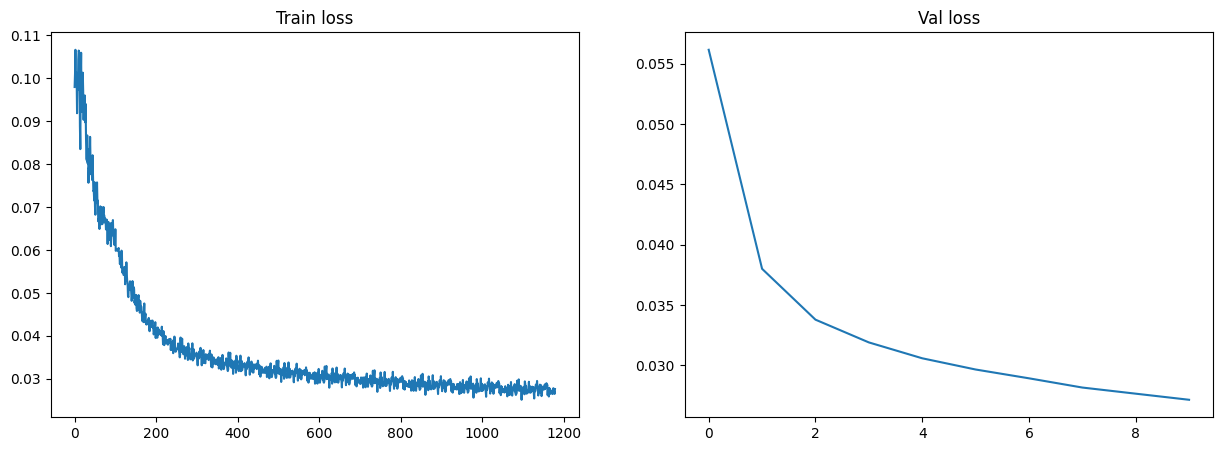

In [8]:
# Plot learning curves
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
axes[0].set_title('Train loss')
axes[0].plot(train_losses)
axes[1].set_title('Val loss')
axes[1].plot(val_losses)


## Model validation

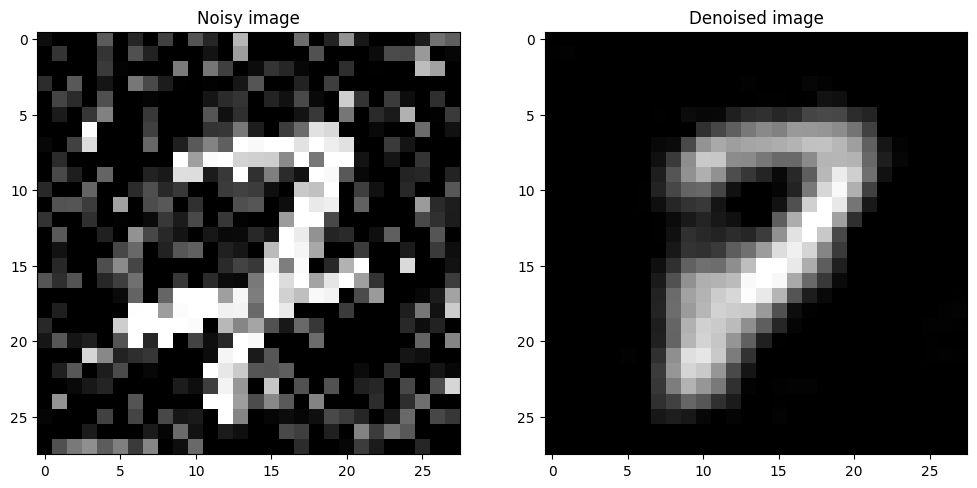

In [9]:
# Get sample
val_img, _ = sample(list(val_dataset), 1)[0]

# Add noise
noisy_val_img = add_noise(val_img)

# Predict denoised image
model.eval()
with torch.no_grad(): output = model(noisy_val_img.to(device)[None, ...])[0, ...]
denoised_val_img = output.clip(0, 1).cpu().numpy()

# Plot sample
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].set_title('Noisy image')
axes[0].imshow(noisy_val_img[0], cmap='gray')
axes[1].set_title('Denoised image')
axes[1].imshow(denoised_val_img[0], cmap='gray')